In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from indicnlp.tokenize import indic_tokenize
import pickle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import json
import matplotlib.pyplot as plt
import os 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
train_file_path = 'forward_train.json'
test_file_path = 'forward_test.json'
val_file_path = 'forward_val.json'

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    if file_path == 'forward_train.json':
        rows = data['train']
    elif file_path == 'forward_test.json':
        rows = data['test']
    elif file_path == 'forward_val.json':
        rows = data['validation']
    df = pd.DataFrame(rows)
    return df

train_data = load_data(train_file_path)
test_data = load_data(test_file_path)
val_data = load_data(val_file_path)

# Tokenization and token length statistics
def tokenize_data(data):
    data['premise_tokens'] = data['premise'].apply(lambda x: indic_tokenize.trivial_tokenize(x))
    data['hypothesis_tokens'] = data['hypothesis'].apply(lambda x: indic_tokenize.trivial_tokenize(x))
    return data

train_data = tokenize_data(train_data)
test_data = tokenize_data(test_data)
val_data = tokenize_data(val_data)



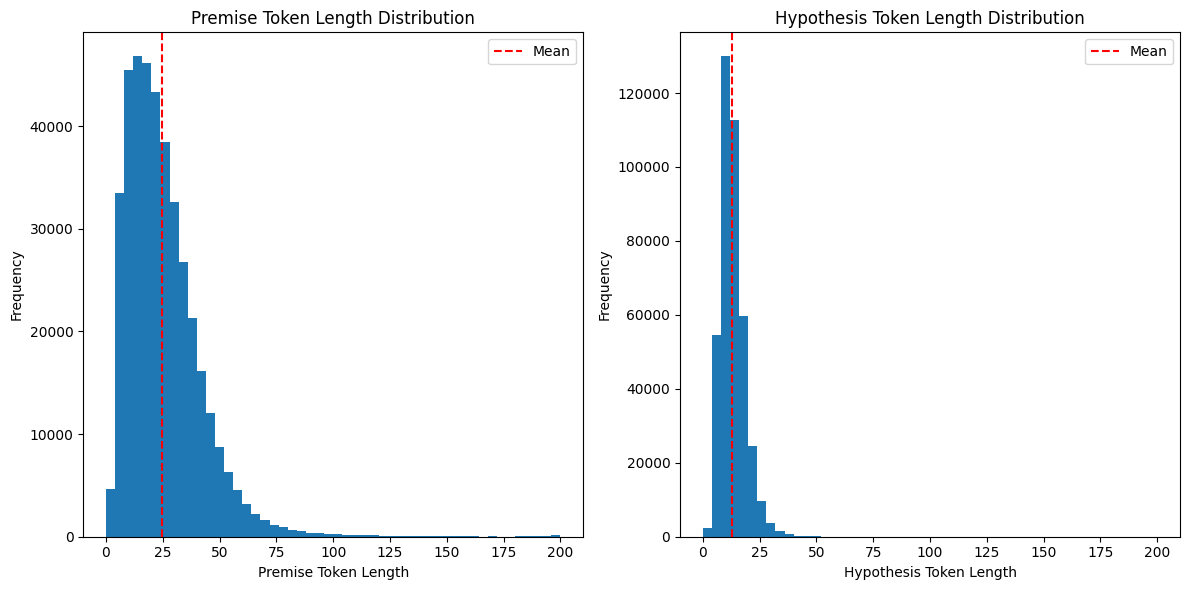

In [5]:
train_premise_lengths = train_data['premise_tokens'].apply(len)
train_hypothesis_lengths = train_data['hypothesis_tokens'].apply(len)
test_premise_lengths = test_data['premise_tokens'].apply(len)
test_hypothesis_lengths = test_data['hypothesis_tokens'].apply(len)
val_premise_lengths = val_data['premise_tokens'].apply(len)
val_hypothesis_lengths = val_data['hypothesis_tokens'].apply(len)

all_premise_lengths = pd.concat([train_premise_lengths, test_premise_lengths, val_premise_lengths])
all_hypothesis_lengths = pd.concat([train_hypothesis_lengths, test_hypothesis_lengths, val_hypothesis_lengths])

max_premise_length = all_premise_lengths.max()
max_hypothesis_length = all_hypothesis_lengths.max()
mean_premise_length = all_premise_lengths.mean()
mean_hypothesis_length = all_hypothesis_lengths.mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(all_premise_lengths, bins=50, range=(0, max_premise_length))
ax1.axvline(mean_premise_length, color='r', linestyle='--', label='Mean')
ax1.set_xlabel('Premise Token Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Premise Token Length Distribution')
ax1.legend()

ax2.hist(all_hypothesis_lengths, bins=50, range=(0, max_hypothesis_length))
ax2.axvline(mean_hypothesis_length, color='r', linestyle='--', label='Mean')
ax2.set_xlabel('Hypothesis Token Length')
ax2.set_ylabel('Frequency')
ax2.set_title('Hypothesis Token Length Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
premise_padding_length = int(np.ceil(mean_premise_length))*2
hypothesis_padding_length = int(np.ceil(mean_hypothesis_length))*2

In [7]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, wt_mat):
        super(ElmoProcessor, self).__init__()
        self.lstmf1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=False, batch_first=True)
        self.lstmf2 = nn.LSTM(hidden_dim, hidden_size=hidden_dim, bidirectional=False, batch_first=True)
        self.embedding = wt_mat.to(device)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, embeddingdata):
        emb = torch.tensor(self.embedding(embeddingdata.to(device)))
        emb_f = emb
        o1f1, h1f1 = self.lstmf1(emb_f)
        o2f2, h2f2 = self.lstmf2(o1f1)
        output = self.linear(o2f2)
        return output, o1f1, o2f2


In [8]:
# Load the word_to_ix mapping
with open('word_to_ix.pkl', 'rb') as file:
    word_to_ix = pickle.load(file)

forward_model_path = 'pretrained_forward_model'
backward_model_path = 'pretrained_backward_model'
forward_model = torch.load(forward_model_path, map_location=torch.device('cpu'))
backward_model = torch.load(backward_model_path, map_location=torch.device('cpu'))


# Padding function
def pad_sequence(tokens, max_length, padding_value):
    padded_tokens = tokens[:max_length] + [padding_value] * (max_length - len(tokens))
    return padded_tokens

# Create a mapping between labels and integer indices
label_to_idx = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

def convert_to_indices(premise_tokens, hypothesis_tokens, label, word_to_ix, max_premise_length, max_hypothesis_length):
    premise_indices = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in premise_tokens]
    hypothesis_indices = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in hypothesis_tokens]
    label_index = label
    padded_premise_indices = pad_sequence(premise_indices, max_premise_length, word_to_ix['<PAD>'])
    padded_hypothesis_indices = pad_sequence(hypothesis_indices, max_hypothesis_length, word_to_ix['<PAD>'])
    return padded_premise_indices, padded_hypothesis_indices, label_index


In [9]:
# NLI dataset class
class NLIDataset(Dataset):
    def __init__(self, data, word_to_ix, max_premise_length, max_hypothesis_length):
        self.data = data
        self.word_to_ix = word_to_ix
        self.max_premise_length = max_premise_length
        self.max_hypothesis_length = max_hypothesis_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        premise_tokens = self.data.iloc[index]['premise_tokens']
        hypothesis_tokens = self.data.iloc[index]['hypothesis_tokens']
        label = self.data.iloc[index]['label']
        premise_indices, hypothesis_indices, label_index = convert_to_indices(
            premise_tokens, hypothesis_tokens, label, self.word_to_ix,
            self.max_premise_length, self.max_hypothesis_length
        )
        return torch.tensor(premise_indices), torch.tensor(hypothesis_indices), torch.tensor(label_index)

class NLIModel(nn.Module):
    def __init__(self, forward_model, backward_model, embedding_dim, hidden_size, num_labels):
        super(NLIModel, self).__init__()
        self.forward_model = forward_model
        self.backward_model = backward_model
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.param0 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.param1 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.param2 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.bilstm = nn.LSTM(input_size=embedding_dim*2, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 4, num_labels)

    def forward(self, premise, hypothesis):
        _, premise_o1f1, premise_o2f2 = self.forward_model(premise)
        _, hypothesis_o1f1, hypothesis_o2f2 = self.forward_model(hypothesis)

        # Flip the premise and hypothesis tensors for the backward model
        premise_flipped = premise.flip(1)
        hypothesis_flipped = hypothesis.flip(1)

        _, premise_o1b1, premise_o2b2 = self.backward_model(premise_flipped)
        _, hypothesis_o1b1, hypothesis_o2b2 = self.backward_model(hypothesis_flipped)

        # Flip the backward model outputs back to the original order
        premise_o1b1 = premise_o1b1.flip(1)
        premise_o2b2 = premise_o2b2.flip(1)
        hypothesis_o1b1 = hypothesis_o1b1.flip(1)
        hypothesis_o2b2 = hypothesis_o2b2.flip(1)

        premise_emb = self.forward_model.embedding(premise)
        hypothesis_emb = self.forward_model.embedding(hypothesis)

        premise_e = torch.cat([premise_emb, premise_emb], dim=2)
        hypothesis_e = torch.cat([hypothesis_emb, hypothesis_emb], dim=2)

        premise_h1 = torch.cat([premise_o1f1, premise_o1b1], dim=2)
        hypothesis_h1 = torch.cat([hypothesis_o1f1, hypothesis_o1b1], dim=2)

        premise_h2 = torch.cat([premise_o2f2, premise_o2b2], dim=2)
        hypothesis_h2 = torch.cat([hypothesis_o2f2, hypothesis_o2b2], dim=2)

        premise_weighted = self.param0 * premise_e + self.param1 * premise_h1 + self.param2 * premise_h2
        hypothesis_weighted = self.param0 * hypothesis_e + self.param1 * hypothesis_h1 + self.param2 * hypothesis_h2

        premise_out, _ = self.bilstm(premise_weighted)
        hypothesis_out, _ = self.bilstm(hypothesis_weighted)

        # Concatenate the last hidden states of premise and hypothesis
        combined_out = torch.cat((premise_out[:, -1, :], hypothesis_out[:, -1, :]), dim=1)
        out = self.fc(combined_out)

        return out

# Create data loaders
train_dataset = NLIDataset(train_data, word_to_ix, premise_padding_length, hypothesis_padding_length)
test_dataset = NLIDataset(test_data, word_to_ix, premise_padding_length, hypothesis_padding_length)
val_dataset = NLIDataset(val_data, word_to_ix, premise_padding_length, hypothesis_padding_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
# Initialize the NLI model
embedding_dim = 300
hidden_size = 256
num_labels = len(label_to_idx)
if os.path.exists('prediction'):
    model = torch.load('prediction')
    model.to(device)
    print("Loaded trained model from file.")
else:
    model = NLIModel(forward_model, backward_model, embedding_dim, hidden_size, num_labels).to(device)

    print("Initialized a new model.")

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i, (premise_indices, hypothesis_indices, label_indices) in enumerate(train_loader):
            premise_indices = premise_indices.to(device)
            hypothesis_indices = hypothesis_indices.to(device)
            label_indices = label_indices.to(device)
            outputs = model(premise_indices, hypothesis_indices)
            loss = criterion(outputs, label_indices)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_true_labels = []
            val_pred_labels = []
            for i, (premise_indices, hypothesis_indices, label_indices) in enumerate(val_loader):
                premise_indices = premise_indices.to(device)
                hypothesis_indices = hypothesis_indices.to(device)
                label_indices = label_indices.to(device)
                outputs = model(premise_indices, hypothesis_indices)
                loss = criterion(outputs, label_indices)
                val_loss += loss.item()
                predicted_labels = torch.argmax(outputs, dim=1)
                val_true_labels.extend(label_indices.tolist())
                val_pred_labels.extend(predicted_labels.tolist())
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
            val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_true_labels, val_pred_labels, average='weighted')
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

    # Save the trained model
    torch.save(model, 'prediction')
    print("Saved the trained model to file.")

Loaded trained model from file.


In [11]:


# Testing
model.eval()
test_true_labels = []
test_pred_labels = []
for i, (premise_indices, hypothesis_indices, label_indices) in enumerate(test_loader):
    premise_indices = premise_indices.to(device)
    hypothesis_indices = hypothesis_indices.to(device)
    label_indices = label_indices.to(device)
    outputs = model(premise_indices, hypothesis_indices)
    predicted_labels = torch.argmax(outputs, dim=1)
    test_true_labels.extend(label_indices.tolist())
    test_pred_labels.extend(predicted_labels.tolist())
test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_true_labels, test_pred_labels, average='weighted')
print(f'Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

def test_example(premise, hypothesis):
    premise_tokens = indic_tokenize.trivial_tokenize(premise)
    hypothesis_tokens = indic_tokenize.trivial_tokenize(hypothesis)
    premise_indices = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in premise_tokens]
    hypothesis_indices = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in hypothesis_tokens]
    padded_premise_indices = pad_sequence(premise_indices, premise_padding_length, word_to_ix['<PAD>'])
    padded_hypothesis_indices = pad_sequence(hypothesis_indices, hypothesis_padding_length, word_to_ix['<PAD>'])
    premise_tensor = torch.tensor([padded_premise_indices]).to(device)
    hypothesis_tensor = torch.tensor([padded_hypothesis_indices]).to(device)
    with torch.no_grad():
        output = model(premise_tensor, hypothesis_tensor)
        predicted_label_idx = torch.argmax(output, dim=1).item()
        predicted_label = idx_to_label[predicted_label_idx]
    return predicted_label


/tmp/ipykernel_40375/3148534607.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embedding(embeddingdata.to(device)))


Test Accuracy: 0.5517, Test F1: 0.5500


/tmp/ipykernel_40375/3148534607.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embedding(embeddingdata.to(device)))



Classification Report:
               precision    recall  f1-score   support

   entailment       0.53      0.54      0.53      1670
contradiction       0.52      0.47      0.49      1670
      neutral       0.60      0.64      0.62      1670

     accuracy                           0.55      5010
    macro avg       0.55      0.55      0.55      5010
 weighted avg       0.55      0.55      0.55      5010

Normalized Confusion Matrix
[[0.54251497 0.24371257 0.21377246]
 [0.32275449 0.46886228 0.20838323]
 [0.16706587 0.18922156 0.64371257]]


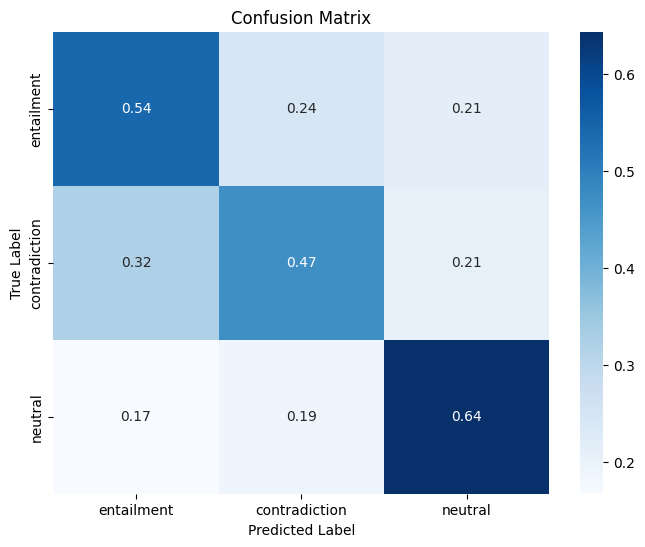

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

# Testing
model.eval()
test_true_labels = []
test_pred_labels = []
for i, (premise_indices, hypothesis_indices, label_indices) in enumerate(test_loader):
    premise_indices = premise_indices.to(device)
    hypothesis_indices = hypothesis_indices.to(device)
    label_indices = label_indices.to(device)
    outputs = model(premise_indices, hypothesis_indices)
    predicted_labels = torch.argmax(outputs, dim=1)
    test_true_labels.extend(label_indices.tolist())
    test_pred_labels.extend(predicted_labels.tolist())

# Classification Report
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=list(label_to_idx.keys())))

# Confusion Matrix
plot_confusion_matrix(test_true_labels, test_pred_labels, classes=list(label_to_idx.keys()), normalize=True)

In [13]:
premise = "अवधारणात्मक रूप से क्रीम स्किमिंग के दो बुनियादी घटक होते हैं।"
hypothesis = "उत्पाद और भूगोल क्रीम स्किमिंग का काम करते हैं।"
predicted_label = test_example(premise, hypothesis)
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"Predicted Label: {predicted_label}")

Premise: अवधारणात्मक रूप से क्रीम स्किमिंग के दो बुनियादी घटक होते हैं।
Hypothesis: उत्पाद और भूगोल क्रीम स्किमिंग का काम करते हैं।
Predicted Label: contradiction


/tmp/ipykernel_40375/3148534607.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embedding(embeddingdata.to(device)))


Three examples for each type of relationship between a premise and a hypothesis in Hindi, covering entailment, contradiction, and neutral.

### Entailment

**Premise:** वह पुस्तकालय गया।

1. **Hypothesis:** वह किताबें पढ़ने के लिए गया।

2. **Hypothesis:** वह अध्ययन करने के लिए गया।

3. **Hypothesis:** वह ज्ञान प्राप्त करने के लिए गया।


### Contradiction

**Premise:** रमेश स्कूल नहीं गया क्योंकि वह बीमार था।

1. **Hypothesis:** रमेश स्कूल गया क्योंकि उसकी तबियत ठीक थी।

2. **Hypothesis:** रमेश ने स्कूल में अपनी कक्षा की प्रस्तुति दी।

3. **Hypothesis:** रमेश स्कूल खेलने गया।

### Neutral
**Premise:** आज बारिश हो रही है।

1. **Hypothesis:** सड़कों पर ट्रैफिक ज्यादा होगा।

2. **Hypothesis:** रोहन आज छतरी लेकर बाहर गया।

3. **Hypothesis:** मौसम विभाग ने आज चेतावनी जारी की।



In [14]:
print("Example 1: Entailment")
premise = "वह पुस्तकालय गया।"
hypotheses = [
    "वह किताबें पढ़ने के लिए गया.",
    "वह अध्ययन करने के लिए गया.",
    "वह ज्ञान प्राप्त करने के लिए गया."
]

for hypothesis in hypotheses:
    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Predicted Label: {test_example(premise, hypothesis)}\n")

print("Example 2: Contradiction")
premise = "रमेश स्कूल नहीं गया क्योंकि वह बीमार था।"
hypotheses = [
    "रमेश स्कूल गया क्योंकि उसकी तबियत ठीक थी.",
    "रमेश ने स्कूल में अपनी कक्षा की प्रस्तुति दी.",
    "रमेश स्कूल खेलने गया."
]

for hypothesis in hypotheses:
    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Predicted Label: {test_example(premise, hypothesis)}\n")

print("Example 3: Neutral")
premise = "आज बारिश हो रही है।"
hypotheses = [
    "सड़कों पर ट्रैफिक ज्यादा होगा.",
    "रोहन आज छतरी लेकर बाहर गया.",
    "मौसम विभाग ने आज चेतावनी जारी की."
]

for hypothesis in hypotheses:
    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Predicted Label: {test_example(premise, hypothesis)}\n")

Example 1: Entailment
Premise: वह पुस्तकालय गया।
Hypothesis: वह किताबें पढ़ने के लिए गया.
Predicted Label: contradiction

Premise: वह पुस्तकालय गया।
Hypothesis: वह अध्ययन करने के लिए गया.
Predicted Label: entailment

Premise: वह पुस्तकालय गया।
Hypothesis: वह ज्ञान प्राप्त करने के लिए गया.
Predicted Label: entailment

Example 2: Contradiction
Premise: रमेश स्कूल नहीं गया क्योंकि वह बीमार था।
Hypothesis: रमेश स्कूल गया क्योंकि उसकी तबियत ठीक थी.
Predicted Label: contradiction

Premise: रमेश स्कूल नहीं गया क्योंकि वह बीमार था।
Hypothesis: रमेश ने स्कूल में अपनी कक्षा की प्रस्तुति दी.
Predicted Label: neutral

Premise: रमेश स्कूल नहीं गया क्योंकि वह बीमार था।
Hypothesis: रमेश स्कूल खेलने गया.
Predicted Label: neutral

Example 3: Neutral
Premise: आज बारिश हो रही है।
Hypothesis: सड़कों पर ट्रैफिक ज्यादा होगा.
Predicted Label: entailment

Premise: आज बारिश हो रही है।
Hypothesis: रोहन आज छतरी लेकर बाहर गया.
Predicted Label: entailment

Premise: आज बारिश हो रही है।
Hypothesis: मौसम विभाग ने आज 

/tmp/ipykernel_40375/3148534607.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embedding(embeddingdata.to(device)))
